# Train vs validation loss curves (GCN + QM9, target 2)

This notebook plots the training supervised loss and validation MSE over epochs
for each of the three trainers (Supervised Ensemble, Mean Teacher, n-CPS Ensemble)
using the improved GCN and the new QM9 datamodule on target 2.

**Prerequisite:** run `configs/scripts/gcn_train_val_curves_qm9.sh` first so that
`results/gcn_train_val_curves_qm9_results.json` exists.

In [3]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

# Load results from the train/val curves script
results_path = Path("results/gcn_train_val_curves_qm9_results.json")
if not results_path.is_file():
    raise FileNotFoundError(
        f"Results file not found at {results_path}.\n"
        "Run 'bsub < configs/scripts/gcn_train_val_curves_qm9.sh' from the repo root first."
    )

with results_path.open("r") as f:
    data = json.load(f)

entries = data.get("results", [])
if not entries:
    raise ValueError("No entries found in results JSON. Did the script finish successfully?")

# Group entries by trainer name (should be one per trainer, but we keep it generic).
by_trainer = {}
for e in entries:
    name = e.get("trainer", e.get("trainer_id", "unknown"))
    by_trainer.setdefault(name, []).append(e)

sorted(by_trainer.keys())

['Mean Teacher', 'Supervised Ensemble', 'n-CPS Ensemble']

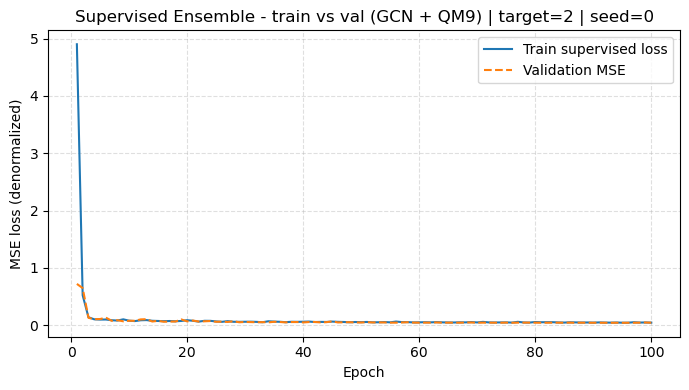

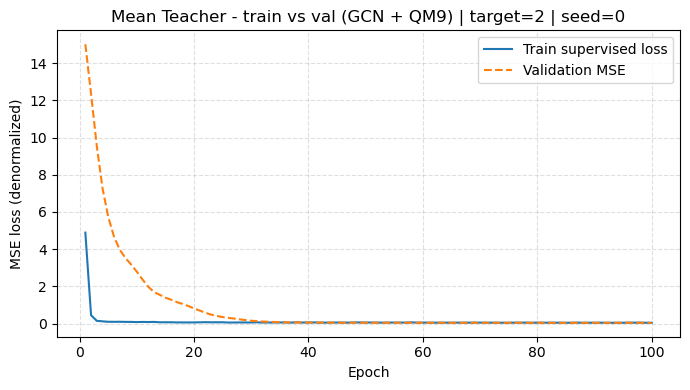

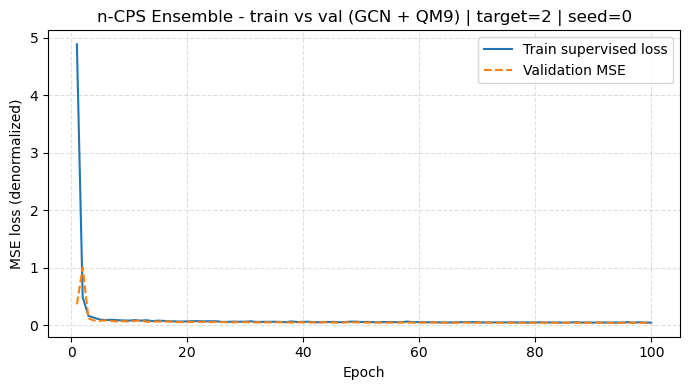

In [4]:
"""Plot train vs validation curves for each trainer in a separate figure (from epoch 5 onward)."""
start_epoch = 5

for trainer_name, runs in by_trainer.items():
    # If there are multiple runs for the same trainer, just take the first.
    entry = runs[0]

    epochs = entry.get("epochs", [])
    train = entry.get("train_supervised_loss", [])
    val = entry.get("val_MSE", [])
    target = entry.get("target", None)
    seed = entry.get("seed", None)

    if not epochs:
        print(f"Skipping {trainer_name}: no epoch history found.")
        continue

    # Filter to epochs >= start_epoch
    filtered = [
        (e, t, v) for e, t, v in zip(epochs, train, val) if e >= start_epoch
    ]
    if not filtered:
        print(f"Skipping {trainer_name}: no epochs >= {start_epoch}.")
        continue

    epochs_f, train_f, val_f = zip(*filtered)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs_f, train_f, label="Train supervised loss", linestyle="-")
    plt.plot(epochs_f, val_f, label="Validation MSE", linestyle="--")

    title = f"{trainer_name} - train vs val (GCN + QM9)"
    if target is not None:
        title += f" | target={target}"
    if seed is not None:
        title += f" | seed={seed}"

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss (denormalized)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
